## FIRST STEPS IN EXPLORING EEG DATA

Now that we have visualized and explore EEG data using Anywave, we will try to carry out similar work using Python and Python-MNE, a tool used by many researchers in EEG, MEG and fMRI.
Make sure that the folders containing your data are in the same directory as your Jupyter notebooks and Python scripts. This will make it easier to load in data.


In [68]:
%matplotlib widget
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pyedflib
import mne
import ipympl
import pandas as pd

sns.set(rc={'figure.figsize':(8, 6)},
        font_scale=1.5)
sns.set_style('whitegrid')

qt_api = os.environ.get('QT_API')


In [69]:
fname = './AuditoryOddball_TBI/sub-004/session1/sub-004_ses-01_task-ThreeStimAuditoryOddball_eeg.edf'
rawmed1 = pyedflib.EdfReader(fname)
n = rawmed1.signals_in_file
signal_labels = rawmed1.getSignalLabels()
sigbufs = np.zeros((n, rawmed1.getNSamples()[0]))
for i in np.arange(n):
        sigbufs[i, :] = rawmed1.readSignal(i)

OSError: ./AuditoryOddball_TBI/sub-004/session1/sub-004_ses-01_task-ThreeStimAuditoryOddball_eeg.edf: file has already been opened

Text(0.5, 0, 'time (seconds)')

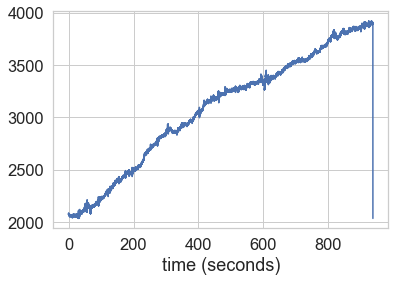

In [71]:
## -----------------------We know the sampling rate of the data, so can construct the time vector.----------------------
srate = 500
datasize = sigbufs.shape

i = range(0, datasize[1])
time = [item * (1/srate) for item in i]   # Create a time vector

%matplotlib inline
## Now we can plot the data of a single electrode over time.
## We want to plot the Cz electrode...
chanidx = signal_labels.index('Cz')      # Find the index of the Cz electrode.
plt.plot(time,sigbufs[chanidx, :])       # Plot the Cz signal
plt.xlabel('time (seconds)')


In [ ]:
### But we may want to visualize individual channel data for a pre-defined time interval.
"""Need to consctruct the new time vector"""
lims_sec    = np.array([60, 70])               # We will define the limits of the time interval, from 60seconds to 70seconds
lim1, lim2  = (lims_sec * srate).astype(int)   # Find the indices of the start and end of chosen time interval
chan2plot   = 'Pz'                             # The index of the channel that you want to plot
chanindx2   = signal_labels.index(chan2plot)
RawIn_sel   = sigbufs[chanindx2, lim1:lim2]     # Extract the raw data of interest

# Now plot the time interval of data.
t = time[lim1:lim2]
plt.plot(t,RawIn_sel)
plt.show()

In [ ]:

chans_sel    = ['C3', 'Cz', 'C4']                                     # The index of the channel that you want to plot
chanidx3 = [signal_labels.index(item2) for item2 in chans_sel ]

RawIn_sel2 = sigbufs[chanidx3, lim1:lim2]        # Etract the data from the
yoffset    = np.array([.001, 0, .001])              # Define a y-offset to seperate the channels
y          = RawIn_sel2.T + yoffset                         # Extract the magnitude data for the selected channel

pline = plt.plot(t, y)
plt.xlabel('Time (seconds)')
plt.ylabel('Magnitude')
plt.legend(pline, chans_sel)
plt.show()

## Convert the continuous data into an MNE Raw object.
![](figures/mne.png)

The Python-MNE package is very employed is the analysis of EEG and MEG data.
MNE-Python provides many functions to visualize and explore EEG data.

We create a what is called in MNE-Python a **Raw object** using the data that we loaded above.
To create this Raw object we will need the following information:
- the sampling rate (in Hertz) of the data
- channel labels
- channel types (EEG, EOG, MEG etc.)

Of course, to create this raw object and to begin using the MNE functions, we need to have imported mne package.
You will notice above that we do not include all the channels when creating the MNE Raw object, we exclude the external channels, EXG1 and EG2


In [ ]:

## ---------------- It is much easier to manipulate and visualize the data using the MNE Package -----------------------.
"""
    So we will create a simple MNE raw object.
    Initialize an info structure with the following information:
    - sampling rate (srate)
    - channel labels (signal_labels)
    - channel types (eeg) - we need to create this list
"""
# Create the channel type list. All channels are type EEG.

siglabs   = signal_labels  # Only include channels from 0 to 66 (exclude external channels except EXG1 and EG2)
chantypes = ['eeg'] * len(siglabs)
sigIn     = sigbufs[0:len(siglabs), :]
info = mne.create_info(ch_names=siglabs, ch_types=chantypes, sfreq=srate)
RawIn = mne.io.RawArray(sigIn, info)

In [ ]:

RawIn.drop_channels('Status')
RawIn.set_channel_types({'VEOG': 'eog'})

### The **Raw object**
If you take a look inside the **RawIn** object, you will see that it has different *attributes* such as:
- n_times : number of time samples
- ch_names : the names of the channels
- times : the time vector
- an *info* dictionnary with acquisition details such as sampling rate, labels of channels marked as *bad* etc.

Below we will access this information and print it to screen.

In [ ]:
## ---------------------------------------------Get some basic information from the data--------------------------------
T = RawIn.times
Allchans =  RawIn.info['ch_names']
badchans =  RawIn.info['bads']
sampfreq =  RawIn.info['sfreq']

print('The sampling frequency is: []', sampfreq)
print('The first 5 channel names are: {}'.format(', '.join(Allchans[:5])))     # Titles of the first 5 electrodes


### Plotting All EEG Channels

Now we will plot the raw signals of all channels stacked on above the other over time.
In the following two cells, we apply two different ways of plotting the EEG signals.

Note that **remove_dc** is set to **True** or "On". What do you think this means?

What might we expect if we set **remove_dc** to **False**?

In [ ]:
##### Visualise all electrode activity #####

%matplotlib widget
mne.viz.plot_raw(RawIn, scalings='auto', remove_dc=True)

In [ ]:

## We can also plot the data in the RawIn object by using RawIn's '"plot" method
RawIn.plot(duration= 20, start = 60, scalings='auto', remove_dc=True, )

#### WHAT IF WE WANT TO PLOT ONLY A SPECIFIC TIME INTERVAL?

In the cell below, you have to plot a single channel, Cz, over the for the 60-70second time window.
You first need to construct the time vector.


Some help:
- You will need to know the sampling frequency (Hz or samples per second) of the data.
- The time vector and data vector, corresponding to data from Cz electrode, need to have the same length.
- Need to find the index of Cz electrode.

In [ ]:
### But we may want to visualize individual channel data for a pre-defined time interval.
"""Need to consctruct the new time vector"""
lims_sec    = np.array([60, 70])
lim1, lim2  = (lims_sec * sampfreq).astype(int)   # Find the indices of the start and end of chosen time interval
chan_idx    = Allchans.index('Cz')                # The index of the channel that you want to plot
RawIn_sel = RawIn[chan_idx, lim1:lim2]     # Extract the raw data of interest

%matplotlib inline
t = RawIn_sel[1]                             # Extract the time vector
y = RawIn_sel[0].T                           # Extract the magnitude data for the selected channel
plt.plot(t, y)
plt.xlabel('Time (seconds)')
plt.ylabel('Magnitude')
plt.show()

#### USE OF RAW METHODS TO GET THE INDICES OF TIME POINTS (IN SECONDS)
The Raw method **time_as_index()** can be used to convert a time, in seconds, into an integer index.
The times can be presented as a list or an array of times and, in that case, will return an array of indices.

In addition, we can also index our Raw object, RawIn, using the channel names rather than the indices.
Here we select 3 central channels to plot in a stacked plot.
So as to differentiate the signals of each channel, we define an offset for the y axis.

In [ ]:
## Use of the Raw method "time_as_index" to find the index
Lims = RawIn.time_as_index(lims_sec)
list_idx = Lims.tolist()
print('The start and end indices of the 60 to 70sec time interval is : ', list_idx)

chan_sel    = ['C3', 'Cz', 'C4']                                     # The index of the channel that you want to plot
RawIn_sel2 = RawIn[chan_sel, Lims[0]:Lims[1]]
yoffset = np.array([.001, 0, .001])
t = RawIn_sel2[1]                             # Extract the time vector
y = RawIn_sel2[0].T + yoffset                         # Extract the magnitude data for the selected channel
pline = plt.plot(t, y)
plt.xlabel('Time (seconds)')
plt.ylabel('Magnitude')
plt.legend(pline, chan_sel)

### ---------------------------------- PLOT TOPOGRAPHIES FOR DEFINED TIME INTERVAL -----------------------------------

In addition to looking at the signal as a function of time.
We can look at the spatial distribution of activity across the head (topography) for a given time interval.
We could do this to highlight activity as a specific time or verify if certain activity corresponds to an artifact.
The plot a single topography, we need to define a vector of the mean activity over a defined time interval.

- Try to find a time interval containing eye-blinks or ECG or alpha oscillation.
- Note the time interval or intervals.
- Plot the topography of the activity over this time interval.

The function to plot topography is given below.
You can use the EEG artifact, characteristics CheatSheet to help you detect these artifacts.
Note: Before we can visualise the topography, we need to define the electrode layout or **montage** that corresponds
to the current data.
Here we use the standard 10-20 montage.

<img src="figures/10-20_1.jpg" width=520 height=550 /><br />

In [ ]:

montage = mne.channels.make_standard_montage('standard_1020')               # Assigning the standard 10-20 montage
mne.viz.plot_montage(mne.channels.make_standard_montage('standard_1020'))   # Visualize the montage
RawIn.set_montage(montage)     # Apply 10-20 montage to the current raw object.

### THE DC OFFSET

We will start by trying to remove the DC offset, by subtracting the mean activity from the activity of one channel.
Then we will plot the result.
So...
- Let's calculate the mean of a few channels.
- What do you notice about the means? How do we know that there is a DC offset?

Note also the use of the *copy()** method. We use this to make a copy of the original **RawIn** object.
When we apply a method such as, *.pick_channels*, to a raw object, we change that object. Therefore, the copy() method is very useful.

In [ ]:
## To test the effect of the DC offset, we will find the mean of a few electrodes.
"""
    Find the mean of the data from several channels.
    What can we say about the means?
"""
RawIn_temp = RawIn.copy()
RawIn_temp.pick_channels(['F3', 'Fz', 'F4'])
dataIn    = RawIn_temp.get_data()
data_mean = np.mean(dataIn, 1)
Dmean = data_mean.tolist()
print('The mean for each  electrode: {} '.format(Dmean))

## Removing the DC Offset

So, if we think we need to remove the DC offset, we can do the following:
- Subtract the mean of each signal from each time sample of each channel.
- Carry out high-pass filtering to remove the 0Hz
- Carry out **detrending**

In the following, you can compare the effect of subtracting the mean and high-pass filtering.
We can carry out this test on the **RawIn_sel2** data, that consists of 6 channels.

In [ ]:
## Subtract the mean
# We already know the means of the 6 channels, they are stored in the Dmean list and the data_mean array.
# The channel-data of the RawIn_temp object is "dataIn"
chan_demean1 = dataIn[0,] - Dmean[0]
chan_demean2 = dataIn[1,] - Dmean[1]
chan_demean3 = dataIn[2,] - Dmean[2]

%matplotlib inline
## Plot the original and demeaned channels
ax1 = plt.subplot(231)
ax1.margins(0.5)           # Default margin is 0.05, value 0 means fit
ax1.plot(T, dataIn[0,])

ax2 = plt.subplot(232)
ax2.margins(0.5)
ax2.plot(T,dataIn[1,])

ax3 = plt.subplot(233)
ax3.margins(0.5)
ax3.plot(T,dataIn[2,])

ax4 = plt.subplot(234)
ax4.margins(0.5)           # Default margin is 0.05, value 0 means fit
ax4.plot(T, chan_demean1)

ax5 = plt.subplot(235)
ax5.margins(0.5)
ax5.plot(T,chan_demean2)

ax6 = plt.subplot(236)
ax6.margins(0.5)
ax6.plot(T,chan_demean3)

# FILTERING THE EEG SIGNAL

In EEG, we generally filter to remove high frequency artifacts and low frequency drifts.
We can filter our time-domain data, our continuous EEG.
We can also filter our spatial-domain data using spatial filters.

We begin by filtering our time-domain data:
- we apply a high-pass filter to remove low frequency drifts
- we apply a low-pass filter to remove high frequency artifacts.
Here we are going to apply a *high-pass filter* only to try to remove the DC offset.

In [ ]:
## Filter the EEG Signal.
# band-pass filtering in the range 0.1 Hz - 40 Hz
RawIntemp_filt = RawIn_temp.copy().filter(0.1, None, fir_design='firwin')

## Exercise:
Plot the unfiltered, the demeaned and the filtered data of a single electrode to compare the effects subtracting the mean and high-pass filtering.
Write your code in the cell below.

In [ ]:
## Now we can plot the unfiltered data, the demeaned data and the filtered data to compare...

## THE SAMPLING FREQUENCY (Hz) AND DOWNSAMPLING

Represents the number of times per second that the acquisition system samples the continuous EEG.
So, given sampling frequency (or sampling rate) of 1024Hz, this means that the system samples the signal every ______ seconds?

The sampling rate has an effect on the analyses that we can carry out on the EEG.
For example, if we are interested interested in studying EEG activity around 80Hz, sampling frequency needs to be **at least** twice this frequency of interest - this is the **Nyquist Rule**.

However, having a high sampling frequency also implies having a greater volume of data. This can mean longer computing times when we are analysing our data.
Generally, in EEG analysis, we are interested in activity in the 0.1Hz to 80Hz frequency band. This means that we do not necessarily need to have a sampling frequency as high as 1024Hz; a sampling frequency of 512Hz or 250Hz will be sufficient to capture the characteristics of the EEG of interest.

To reduce the rate at which our EEG is sampled, we can **resample** or **downsample** our data.
- How does resampling change the EEG signal?
- What other variable is automatically changed when we resample the EEG data?

In [ ]:
rsamp = 250                                              # Downsample to half of the original sampling frequency.
RawIn_rs = RawIn.copy().resample(sfreq=rsamp)

# FILTERING THE EEG SIGNAL

In EEG, we generally filter to remove high frequency artifacts and low frequency drifts.
We can filter our time-domain data, our continuous EEG.
We can also filter our spatial-domain data using spatial filters.

We begin by filtering our time-domain data:
- we apply a high-pass filter to remove low frequency drifts
- we apply a low-pass filter to remove high frequency artifacts.

#### Exercise:
##### Plot the filtered data to compare with the non-filtered data (**RawIn_rs** object)
##### Can you find any noisy electrodes that we may need to exclude from our data?

In [ ]:
## Filter the EEG Signal.
# band-pass filtering in the range 1 Hz - 40 Hz
RawIn_filt = RawIn_rs.copy().filter(0.1, 40., fir_design='firwin')

In [ ]:

# Write the code below to plot the filtered data...
%matplotlib widget
mne.viz.plot_raw(RawIn_filt, scalings='auto')

## Plotting the Frequency Spectrum of EEG Signals

When trying to detect noisy electrodes it is helpful to look at the frequency spectrum of the electrodes.
The presence of low frequency or high frequency activity with a lot of energy can indicate a noisy electrode.
Below we will plot the **Power Spectral Density (PSD)** for frequencies between 0.5Hz and 40Hz.

In [ ]:
%matplotlib widget
mne.viz.plot_raw_psd(RawIn_filt, fmin=0.5, fmax=40, dB=True)

### Mark the Noisy Channels as "Bad"

Because activity that corresponds to noise is very often of higher amplitude than the EEG activity that interests us.
It is important to detect these souces of noise so that we can exclude them from our analysis.
Here we will mark the noisy channels as **bad** so that we can exclude them from our analysis.

In [ ]:
'''
        We mark a channel as "bad" by adding it to the "bads" attribute of "info".
'''
ChanBad = ['Fp1']
RawIn_filt.info['bads'] = ChanBad

# Plot the PSD again but without the channel marked as "bad".
mne.viz.plot_raw_psd(RawIn_filt, fmin=0.5, fmax=40, dB=True, exclude='bads')

## Re-referencing the EEG:

The potential measured in microVolts is measured in relation to the potential at another point, called the reference.

This means that the activity at each channel is interpreted relative to the potential at a reference.
- the reference can be the mean activity of all electrodes.
- the average of the two mastoids (generally these reference channels are marked as Ref1, Ref2 or EXG1, EXG2)
The current dataset does not have the external (EXG) channels, so we will apply an average reference.

However, we cannot include the bad channels or the VEOG when applying the reference.
We use the *pick_types()* method to exclude these channels when applying the average reference.

<a href="https://predictablynoisy.com/mne-python/generated/mne.set_eeg_reference.html"> Link to MNE page on **mne.set_eeg.reference()**</a>

In [ ]:
# raw.set_eeg_reference(ref_channels, copy=True, verbose=None)

RawIn_ref = RawIn_filt.copy().pick_types(eeg=True, exclude= ['bads','eog']).set_eeg_reference()

## Visual Inspection and Annotation of Data

Visually inspect the raw data, **RawIn_ref** by calling **RawIn_ref.plot()

Bad channels are color coded gray. By clicking the lines or channel names on the left, you can mark or unmark a bad channel interactively. You can use +/- keys to adjust the scale (also = works for magnifying the data). Note that the initial scaling factors can be set with parameter scalings. If you don’t know the scaling factor for channels, you can automatically set them by passing scalings=’auto’. With pageup/pagedown and home/end keys you can adjust the amount of data viewed at once.

You can enter annotation mode by pressing a key. In annotation mode you can mark segments of data (and modify existing annotations) with the left mouse button. You can use the description of any existing annotation or create a new description by typing when the annotation dialog is active. Notice that the description starting with the keyword 'bad' means that the segment will be discarded when epoching the data. Existing annotations can be deleted with the right mouse button. Annotation mode is exited by pressing a again or closing the annotation window.


In [ ]:
### HERE WE WILL MANUALLY ANNOTATE THE CONTINUOUS DATA TO MARK EYE-BLINKS OR BIG ELECTRODE JUMPS
fig = RawIn_ref.plot(block=True)              # Open the interactive raw.plot window. This should open a separate window.
fig.canvas.key_press_event('a')

## Automatic Detection of Eye-Blinks


In [ ]:
eogev_elec = 'AF8'                                #Put the label of your selected electrode here...try different electrodes.
eog_epochs = mne.preprocessing.create_eog_epochs(RawIn_ref, ch_name=eogev_elec, reject_by_annotation=False)
eog_epochs.apply_baseline(baseline=(None, -0.2))  # We go from the start of the interval to the -200ms before 0ms
eog_epochs.average().plot_joint()
eog_epochs.average().plot_topomap()

## Automatic Detection of ECG (Cardiac activity)

In [ ]:
ecg_elec = '';
ecg_epochs = mne.preprocessing.create_ecg_epochs(RawIn_ref, ch_name=ecg_elec, reject_by_annotation=False)
ecg_epochs.apply_baseline(baseline=(, ))              # Can you suggest a baseline interval for ECG??
ecg_epochs.average().plot_joint()
ecg_epochs.average().plot_topomap()

In [ ]:
from matplotlib import cm
### In continuous data, it is more interesting to look at frequency band activity.
spectra, freqs = mne.time_frequency.psd_welch(RawIn_filt, fmin=1, fmax=40, tmin=0, tmax=250,
                                              n_overlap=125, n_fft=250)
print(freqs)       # Print the frequencies to screen.

# Plot the spectra as a function of frequency.
plt.plot(freqs, spectra.T)
plt.ylabel(r'PSD ($\mu$V^2)')

## To start with, lets plot the topography of alpha activity (10Hz) across our continuous data.
layout = mne.find_layout(RawIn_filt.info, ch_type='eeg', exclude='bads')
mne.viz.plot_topomap(spectra[:, 9],layout.pos , cmap=cm.viridis, contours=0)

## Add Event Data to the Dataset

In [74]:
event_data = pd.read_csv(
    './AuditoryOddball_TBI/sub-002/session1/sub-002_ses-01_task-ThreeStimAuditoryOddball_events.csv', sep=';', header=None)
annotations = mne.Annotations(event_data[0], event_data[1], event_data[2])
RawIn_filt.set_annotations(annotations)
events, events_id = mne.events_from_annotations(RawIn_filt)
print(events_id)


Used Annotations descriptions: ['Novel Tone', 'Standard Tone', 'Target Tone']
{'Novel Tone': 1, 'Standard Tone': 2, 'Target Tone': 3}


/var/folders/60/tv1lj_b10zq7ypz5s1kvq4_cr3bc6f/T/ipykernel_46119/2659928595.py:4: RuntimeWarning: Omitted 122 annotation(s) that were outside data range.
  RawIn_filt.set_annotations(annotations)


In [ ]:

## Segmenting the Continuous Data

tmin, tmax = [ -0.1,1 ]
reject_criteria = dict(eeg=40e-6)   # Criterion for epoch rejection
event_dict = {'Novel Tone': 1, 'Standard Tone': 2, 'Target Tone': 3}
# Call of function to segment the data into epochs.
epoch_data = mne.Epochs(RawIn_filt, events, event_id=event_dict, tmin=tmin, tmax=tmax, reject=None, reject_by_annotation=False,
                        baseline=(tmin, 0), preload=True,
                        detrend=None, verbose=True)

fig = mne.viz.plot_events(events, event_id=event_dict, sfreq=RawIn_filt.info['sfreq'],
                          first_samp=RawIn_filt.first_samp)

In [ ]:
%matplotlib widget
epoch_data['Novel Tone'].plot(events=events, event_id=event_dict, butterfly=True)

In [ ]:
epoch_data['Novel Tone'].plot_psd(picks='eeg')

In [ ]:
epoch_data['Novel Tone'].plot_image(picks='eeg', combine='mean')

In [ ]:
epochs_novel = epoch_data['Novel Tone']
epochs_standard = epoch_data['Standard Tone']

# Now we will average over the novel and standard trials. This will give us our evoked activity.
evoked_novel = epochs_novel.average()
evoked_standard = epochs_standard.average()

mne.viz.plot_compare_evokeds(dict(novel=evoked_novel, standard=evoked_standard),
                             legend='upper left', show_sensors='upper right')